<a href="https://colab.research.google.com/github/alvinkli/UROP/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Feature Consistent VAE Implementation on Kaggle Fashion Dataset**




###Introduction

Hey everyone! My name is Alvin Li. I am an MIT undergraduate student studying computer science and working as a deep learning researcher in the MIT Computer Science and Artificial Intelligence Lab (CSAIL). This Colab Notebook documents how I used Tensorflow to build, train, and deploy a deep feature variational autoencoder network on over 40,000 RGB images from the Kaggle Fashion Dataset. The novel architecture I developed uses a pretrained perceptual loss network (EfficientNet) to generate higher quality reconstructions than a standard convolutional VAE.

After implementing the deep feature VAE network, I used the t-distributed stochastic neighbor embedding (t-SNE) algorithm to embed the high dimensional data onto a lower dimensional space and generate a visualization of the latent space. I also used MatPlotLib to construct an interactive sliders interface and a series of grids that display a smooth linear interpolation of the images and their respective reconstructions across the learned latent space.

The ultimate goal of this project was to build the technology behind an ML tool that powers enhanced customer search queries through scraping online retail data sources (ie. Amazon, Nordstrom, Nike, Target, Walmart). This Colab Notebook captures the proof of concept behind this product.

### Setup
To start, I went to the [Kaggle Website](https://www.kaggle.com/paramaggarwal/fashion-product-images-small) and clicked the "Download (565 MB)" button to download a zip file named "archive" that contains the Kaggle Fashion Product Images Dataset. This dataset is comprised of 44,000 high-resolution rgb images of fashion products along with their category labels. The former is stored in a folder named "images", and the latter is stored in a file named "styles.csv" (both are inside of the downloaded zip file). Next, I uploaded the zip file from my desktop to my Google Drive. Do not open up the zip file – uploading the entire dataset folder onto Google Drive will be extremely time consuming. Lastly, I created this [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) notebook, which is a free Jupyter notebook environment that allows you to write and execute Python and TensorFlow in your browser. 

*IMPORTANT NOTE: Before running any of the code below, complete these steps:*

*1) Click on the "Runtime" tab in the toolbar above.*

*2) Click "Change runtime type."*

*3) Make sure the Hardware Accelerator is set to "GPU" – this speeds up the training process by a lot.*

###Load Dataset and Import Relevant Packages
In order to access the contents of the stored zip file, I "mounted" my Google Drive to my Colab Notebook. Running the code below outputs a prompt `Go to this URL in a browser:`. I clicked on the link, logged into my Google account, clicked "Allow", then copied the code and pasted it back into the Colab notebook in the input box under `Enter your authorization code:`. Mounting my Google Drive allows me to access any file on my Google Drive from this Colab notebook.




In [ ]:
'''Allow Access to Google Drive Files'''
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, I imported all the necessary packages and unzipped the "archive" file from my Google Drive. The code below not only extracts the contents of the zip file, but also makes it so that I can view and access the files locally within this Colab notebook just by clicking the folder icon on the left toolbar.

In [ ]:
'''Import Relevant Packages'''
import IPython
import tensorflow as tf
import functools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import glob
import pathlib
import cv2
import random
import logging
import scipy
import ipywidgets as widgets
import pandas as pd
import scipy.stats
import os
import sys
import h5py
import math
import string

from ipywidgets import interactive
from tqdm import tqdm
from scipy.stats import norm
from sklearn import manifold
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from google.colab.patches import cv2_imshow

In [ ]:
'''Unzip File Containing Kaggle Fashion Data'''
!unzip -q "/content/drive/MyDrive/archive.zip"

###Data Preprocessing

Originally, each image in the Kaggle Fashion dataset has dimensions 80 (height) x 60 (width) x 3 (RGB layers). I pre-processed the data by restricting it to the 15k images with the "Topwear" label, resizing each image to 64 x 64 x 3, and dividing each pixel value by 255 to constrain each pixel to a value between 0 and 1. This retains the important structural information of the images while reducing them to a form that can be better used to train and test a neural network.

In [ ]:
'''Retrieve Data Labels'''
labels_dir = pathlib.Path('/content/styles.csv')
names = ["id", "gender", "masterCategory", 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']
labels = pd.read_csv(labels_dir, names=names, skiprows=1)
labels.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


Original Image: 



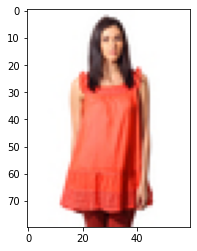


 Preprocessed Image: 



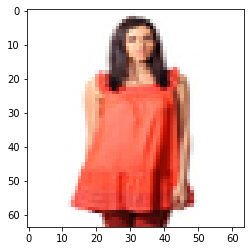


 There are 15396 images in the dataset.

 Each image has the dimensions (64, 64, 3).


In [ ]:
'''Preprocess Data'''
#List of paths to each image file
data_dir = pathlib.Path('/content/images')
image_paths = list(data_dir.glob('*.jpg'))

def findBaseColor(image):
  rgb = [0,0,0]
  for i in range(38,43):
    for j in range(28,33):
      rgb += image[i][j]
  return rgb/25

def preprocess_images(image_paths):
  colors = []
  images = []
  for i in range(len(image_paths)):
    image_path = image_paths[i]
    try:
      id = int(str(image_path)[16:21])
    except:
      id = int(str(image_path)[16:20])
    if labels.loc[labels['id'] == id]['subCategory'].tolist() == ['Topwear']:
      image = matplotlib.image.imread(image_path)
      if images == []:
        temp = (image / 255)
        original_first_image = temp.astype('float32')
      resized_image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
      if resized_image.shape == (64,64,3):
        resized_image = resized_image / 255
        images.append(resized_image.astype('float32'))
        colors.append(findBaseColor(resized_image.astype('float32')).astype('float32'))
  return images, original_first_image, colors

#List of images (each in the form of a 28x28x3 numpy array of rgb pixels)
images, original_first_image, colors = preprocess_images(image_paths)

#Displays the first image in the dataset BEFORE resizing
print("Original Image: \n")
plt.imshow(original_first_image)
plt.show()

#Displays the first image in the dataset after preprocessing
print("\n Preprocessed Image: \n")
plt.imshow(images[0])
plt.show()

#Number of images in the entire dataset
print("\n There are " + str(len(images)) + " images in the dataset.")

#Dimensions of each image in the dataset
print("\n Each image has the dimensions " + str(images[0].shape) + ".")

I split the dataset into a set of training images (80% of the dataset) and a set of testing images (20% of the dataset).

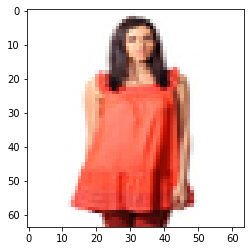

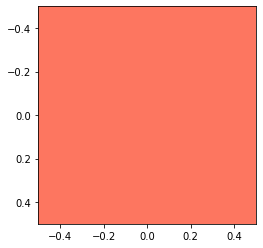

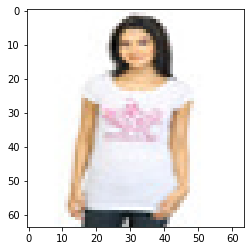

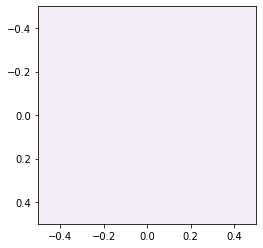

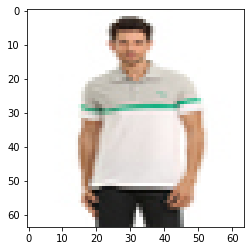

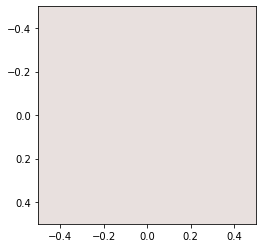

In [ ]:
for i in range(3):
  rgb = findBaseColor(images[i])

  plt.imshow(images[i])
  plt.show()

  plt.imshow([[rgb]])
  plt.show()

In [ ]:
'''Split Dataset into Training and Testing Data'''
train_images = np.array(images[0:int(len(images)*0.8)])
test_images = np.array(images[int(len(images)*0.8):])

train_labels = np.array(colors[0:int(len(images)*0.8)])
test_labels = np.array(colors[int(len(images)*0.8):])

train_size = train_images.shape[0]
test_size = test_images.shape[0]

###Build the DFC-VAE Model


A variational autoencoder (VAE) is a neural network comprised of an encoder and a decoder. The encoder network takes in high dimensional input data and reduces it down to a set of parameters (mean and standard deviation) that describe the data's low dimenensional latent space. The decoder network then samples from the parameters of the latent space to reconstruct the original input data.

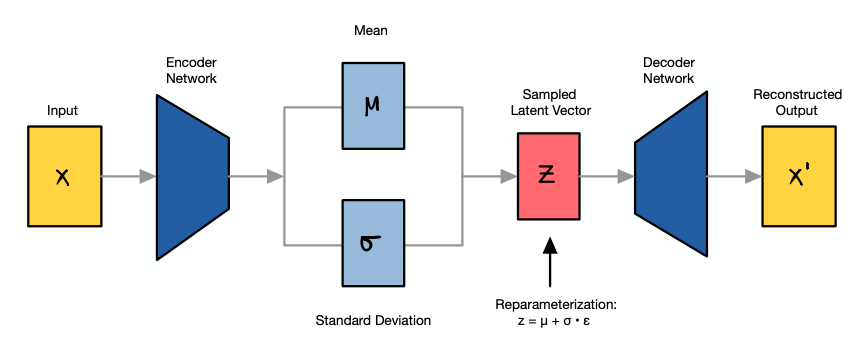

I used a convolutional neural network (CNN) for the encoder portion of the VAE. This includes four Conv2D layers that apply filters/kernels to the input image so that the encoder can extract features and learn a stochastic latent space for the decoder to sample from. They are each followed by a BatchNormalization layer to scale the activations and speed up the learning process. The last few layers are a Flatten layer that flattens the input image to a 1-d array and three fully connected Dense layers. Both the Conv2D layers and the Dense layers use the rectified linear unit (reLU) activation function, which introduces nonlinearities to the encoder by outputting the input if the input is positive and outputing zero if the input is negative.

The decoder portion of the VAE includes three fully connected Dense layers, a Reshape layer, and four Conv2DTranspose layers that reconstruct the input image using the sampled latent variables. Both the Dense layers and the Conv2dTranspose layers use a reLU activation function to introduce nonlinearities to the decoder network.

*Note: A more detailed explanation of CNNs can be found in the [MIT 6.S191 Convolutional Neural Networks Lecture](https://www.youtube.com/watch?v=iaSUYvmCekI&ab_channel=AlexanderAmini).*

In [ ]:
'''Build the Convolutional Encoder and Decoder Networks'''
from tensorflow.keras import layers
n_filters = 12 #Base number of convolutional filters
latent_dim = 5 #Number of latent dimensions
def make_encoder(n_outputs = 1):
  #Functionally define the different layer types
  Input = tf.keras.layers.InputLayer
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  #Build the encoder network using the Sequential API
  encoder = tf.keras.Sequential([

    Input(input_shape=(64, 64, 3)),

    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    # Conv2D(filters=8*n_filters, kernel_size=3,  strides=2),
    # BatchNormalization(),

    # Conv2D(filters=10*n_filters, kernel_size=3,  strides=2),
    # BatchNormalization(),

    Flatten(),

    Dense(512, activation='relu'),

    Dense(512, activation='relu'),

    Dense(2*latent_dim, activation=None),
  ])

  return encoder

def make_decoder():
  #Functionally define the different layer types
  Input = tf.keras.layers.InputLayer
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten

  #Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([

    Input(input_shape=(latent_dim + 3, )),

    Dense(units=4*4*6*n_filters),
    
    Dense(units=4*4*6*n_filters),

    Dense(units=4*4*6*n_filters),

    Reshape(target_shape=(4, 4, 6*n_filters)),

    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),

    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),

    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),

    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

I built the DFC-VAE by subclassing TensorFlow's Model class (`tf.keras.Model`) and using the encoder network and decoder network from above. The `encode()` function feeds an input image "x" into the encoder network, which generates the mean and standard deviation vectors of the learned latent variables z. The `reparameterize()` function uses a stochastic variable $\epsilon$ ~ $Normal(0,1)$ to sample from the parameters of z. Reparameterization is necessary because it allows the network to sample from the latent space while keeping the parameters of z deterministic, which enables backpropagation through the neural network. The equation used to sample from the mean and standard deviation of the encoded latent variables is $ z = \mathbb{\mu} + e^{\left(\frac{1}{2} \cdot \log{\sigma}\right)}\circ \epsilon $

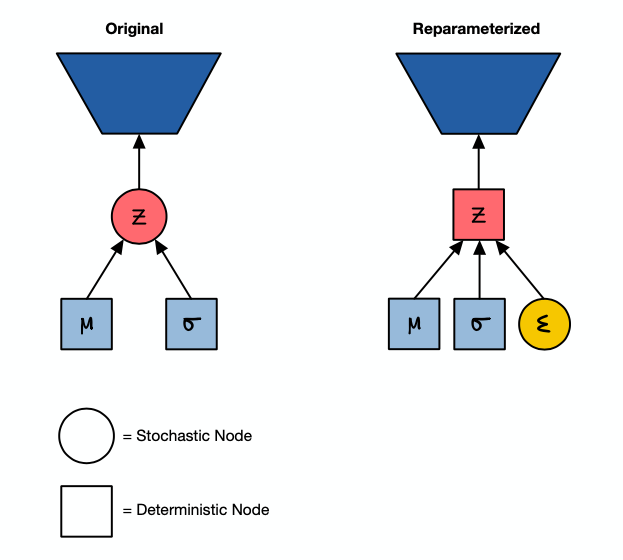

Lastly, the `decode()` function applies a sigmoid activation function to the reparameterized sample z before feeding it into the decoder network, which generates the final reconstruction image.

I also included a `call()` function that completes one forward pass through the entire model. This executes everything above: encode the input image, reparameterize the latent variables, and decode the sample to generate a reconstruction image.

*Note: A more detailed explanation of VAEs can be found in the [Towards Data Science Guide to Understanding VAEs](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)*

In [ ]:
'''Deep Feature Consistent Variational Autoencoder Class'''
class DFC_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DFC_VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = make_encoder()
    self.decoder = make_decoder()

  def encode(self, x):
    z_mean, z_logsigma = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return z_mean, z_logsigma
  
  def reparameterize(self, z_mean, z_logsigma, y):
    eps = tf.random.normal(shape=z_mean.shape)
    new_z_mean = tf.concat([z_mean,y],1)
    latents = eps * tf.exp(z_logsigma * 0.5) + z_mean
    semi_supervised_latents = tf.concat([latents,y],1)
    return semi_supervised_latents

  def decode(self, z, apply_sigmoid=False):
    x_recon = self.decoder(z)
    if apply_sigmoid:
      new_x_recon = tf.sigmoid(x_recon)
      return new_x_recon
    return x_recon

  def call(self, x, y): 
    z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma, y)
    x_recon = self.decode(z)
    return z_mean, z_logsigma, x_recon

I defined the loss function, which is the sum of the latent loss, the pixel-by-pixel reconstruction loss, and the perceptual loss. The latent loss uses the Kullback-Leibler (KL) divergence to measure how far the distribution of learned latent variables are from a unit Gaussian. The element-wise reconstruction loss uses the $L^1$ norm to measure the difference between the reconstructed image and the original ground-truth image. These equations are given below:

Latent Loss: $ \displaystyle L_{KL}(\mu, \sigma) = \frac{1}{2}\sum\limits_{j=0}^{k-1}\small{(\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})} $

Reconstruction loss: $ \displaystyle  L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1 $

The perceptual loss uses the EfficientNetB0 as a pretrained loss network to encode both the original input image and the reconstructed output image into their latent embeddings. Instead of comparing each pixel from the reconstructed output with the corresponding pixel in the ground truth image, the perceptual loss function feeds both the reconstructed output and the ground truth image into the pretrained neural network and computes the difference between their extracted feature representations. By minimizing this difference, the VAE becomes "deep feature consistent", meaning that it takes into account both the the high level and low level feature differences between the inputs and their respective reconstructed outputs. 

A publication from [Stanford University](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) and another from [Luleå University of Technology](https://arxiv.org/pdf/2001.03444.pdf) propose that replacing per-pixel loss functions with perceptual loss functions when training an autoencoder network leads to more accurate reconstructions.


In [ ]:
'''Upload TensorFlow's Pretrained EfficientNetB0 Network'''
percep_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(64,64,3), pooling=None, classes=1000,
    classifier_activation='softmax'
)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
'''Perceptual Loss Function'''
def perceptual_loss_function(x, x_recon, z_mean, z_logsigma, kl_weight=0.00005):
  reconstruction_loss = tf.reduce_mean(tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3)))
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(z_logsigma) + tf.square(z_mean) - 1.0 - z_logsigma, axis=1)
  perceptual_loss = tf.reduce_sum(tf.square(tf.subtract(tf.stop_gradient(percep_model(x)),percep_model(x_recon))))
  # color_loss = tf.reduce_sum(tf.square(z_mean))

  # return kl_weight*latent_loss + reconstruction_loss + 0.015*perceptual_loss + 0.1*color_loss
  return kl_weight*latent_loss + reconstruction_loss + 0.015*perceptual_loss

In [ ]:
'''Perceptual Loss Function'''
def perceptual_loss_function(x, x_recon, z_mean, z_logsigma, kl_weight=0.001):
  reconstruction_loss = tf.reduce_mean(tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3)))
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(z_logsigma) + tf.square(z_mean) - 1.0 - z_logsigma, axis=1)
  perceptual_loss = tf.reduce_sum(tf.square(tf.subtract(tf.stop_gradient(percep_model(x)),percep_model(x_recon))))
  # color_loss = tf.reduce_sum(tf.square(z_mean))

  # return kl_weight*latent_loss + reconstruction_loss + 0.015*perceptual_loss + 0.1*color_loss
  return kl_weight*latent_loss + reconstruction_loss + 0.015*perceptual_loss

-increase kl weight 

-decrease number latent variables

-one data point to another data point linear interpolation

###Train the DFC-VAE Model

I started the training process by initializing the batch size, learning rate, number of latent variables, and number of epochs. The current hyperparameter values have been optimized to balance the model's training speed with the accuracy of the reconstructed images.

Then, I initialized a new VAE model and an optimizer that uses the Adam optimization algorithm for stochastic gradient descent. 

Next, I defined a function `train_step` that completes a single step in the training process. This starts with a forward pass through the neural network that returns a set of parameters. These values are inputted into the VAE loss function to calculate the total loss, which is added to `training_loss_history`. This Python list tracks the training loss progression throughout the entire process. Then, the gradient is calculated using TensorFlow's gradient tape. The Adam optimization algorithm takes in this gradient to perform gradient descent and reweights the trainable variables in the VAE. A similar function `validation_step` uses the test images to track the validation loss progression.

Finally, I trained the VAE model. The training loop iterates through each epoch, batches the training and testing data, and passes the respective batches of images into the `train_step` and `validation_step` functions.

In [ ]:
'''Train the VAE Model'''
#Hyperparameters
batch_size = 32
learning_rate = 1e-3
latent_dim = 5
num_epochs = 80

#Instantiate a new DFC_CVAE model and optimizer
model = DFC_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, model, labels):

  with tf.GradientTape() as tape:
    #Forward pass through the VAE
    z_mean, z_logsigma, x_recon = model.call(x, labels)
    
    #Compute the loss
    loss = perceptual_loss_function(x, x_recon, z_mean, z_logsigma)

  #Calculate gradients
  grads = tape.gradient(loss, model.trainable_variables)

  #Apply gradients to variables using the Adam optimization algorithm
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  #Update record of losses
  return loss

# @tf.function
# def validation_step(x, model):

#   #Forward pass through the VAE
#   z_mean, z_logsigma, x_recon = model.call(x)
  
#   #Compute the loss
#   loss = perceptual_loss_function(x, x_recon, z_mean, z_logsigma)
  
#   return loss

#Track the training and validation losses over time (updated during each step in the training process)
training_loss_history = []
validation_loss_history = []

#Training loop
for i in range(num_epochs):
 
  #Track training progress
  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  #Progress bar
  for j in tqdm(range(train_size // batch_size)):

    #Randomly select a batch of images from the training dataset
    selected_inds = np.random.choice(np.arange(train_size), size=batch_size, replace=False)
    batch_images = []
    batch_labels = []
    for i in selected_inds:
      batch_images.append(train_images[i])
      batch_labels.append(colors[i])
    x = np.array(batch_images)
    y = np.array(batch_labels)

    #Randomly select a batch of images from the validation dataset
    selected_inds = np.random.choice(np.arange(test_size), size=batch_size, replace=False)
    batch_images = []
    for i in selected_inds:
      batch_images.append(test_images[i])
    x_test = np.array(batch_images)

    #Complete a single step in the training process
    training_loss = train_step(x, model, y)
    # validation_loss = validation_step(x_test, model)

    #Track the progression of the loss
    training_loss_history.append(training_loss)
    # validation_loss_history.append(validation_loss)

Starting epoch 80/80


100%|██████████| 384/384 [00:36<00:00, 10.45it/s]


###Test the DFC-VAE Model
To visualize the results of the neural network, I generated two grid-style plots that compare 16 input images within the testing dataset with their respective reconstructed outputs. If the reconstructed images turn out poorly, this means that the hyperparameters need to be adjusted. To help with that, I created a plot that displays both the total training and validation losses over time during the model's training process.

Here are some general guidelines that I found useful for tuning the hyperparameters:

1) The loss should decrease steeply at the start and then plateau. If the line never evens out at the bottom, then the training process is incomplete, and the model needs to be retrained with a larger number of epochs.

2) If the loss decreases too slowly, increase the learning rate. If the loss changes erratically, decrease the learning rate. A good starting learning rate to use is 0.01.

3) Start with larger batch sizes and decrease it if needed. Larger batch sizes lead to a faster training process due to the parallelism of the GPUs, but they also result in a larger generalization error.

4) Typically the more complex the images are, the more latent variables are needed to accurately represent each image.

Original Images:


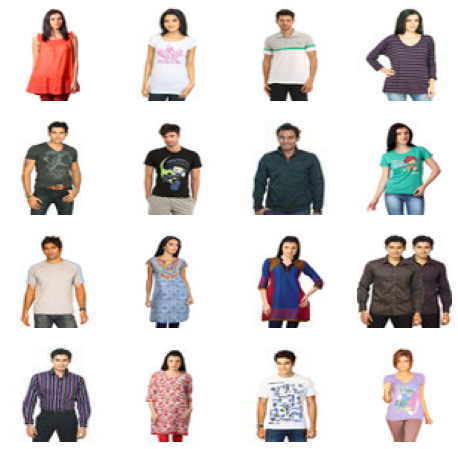


 Reconstructed Images (Perceptual):


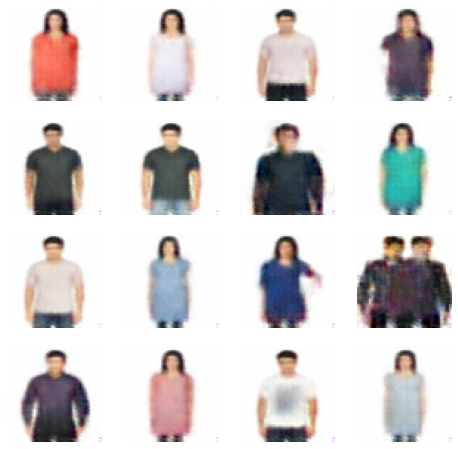

In [ ]:
'''Plot Original Input Images vs. Reconstructed Images'''
def plot_original_images(test_sample):
  fig1 = plt.figure(figsize=(8, 8))

  for i in range(len(test_sample)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_sample[i])
    plt.axis('off')

  print('Original Images:')
  plt.show()

def plot_reconstructed_images(model, x, y):
  z_mean, z_logsigma, x_recon = model.call(np.array(x), y)

  fig1 = plt.figure(figsize=(8, 8))

  for i in range(x_recon.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_recon[i])
    plt.axis('off')

  print('\n Reconstructed Images (Perceptual):')
  plt.show()

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

train_sample = train_images[:16]
train_sample_labels = colors[0:16]
test_sample = random.sample(list(test_images), 16)
plot_original_images(train_sample)
plot_reconstructed_images(model, train_sample, train_sample_labels)

logger.setLevel(old_level)

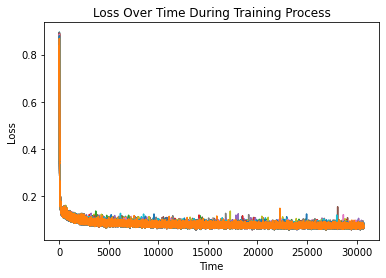

In [ ]:
'''Plot Loss Over Time During the Training Process'''
plt.figure()
plt.plot(training_loss_history)
plt.plot(validation_loss_history)
plt.title('Loss Over Time During Training Process')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

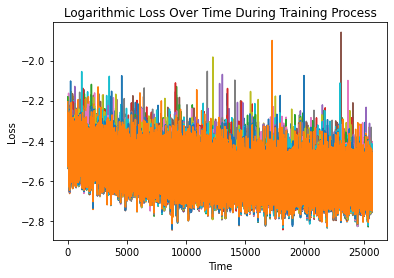

In [ ]:
'''Plot Tail-End of Logarithmic of Loss Over Time During the Training Process'''
plt.figure()
plt.plot(np.log(training_loss_history[5000:]))
plt.plot(np.log(validation_loss_history[5000:]))
plt.title('Logarithmic Loss Over Time During Training Process')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

As you can see, the model's performance on the validation dataset peaks at approximately 80 epochs of training. Based on the quality of the reconstructed outputs, the model successfully extracts key features of the clothing items during the encoding and decoding processes. The use of perceptual loss was a key factor that spearheaded the high accuracy of these reconstructions.

### TSNE Visualization of Latent Space

I generated a 3D representation of the model's entire latent space using a t-distributed stochastic neighbor embedding (t-SNE) algorithm, which allows us to visualise high-dimensional datasets in a lower dimensional space. As you can see, data points that are nearby one another in the latent space share similar high level features.

Computing latent space projection...
Computing t-SNE embedding...
Plotting t-SNE visualization...


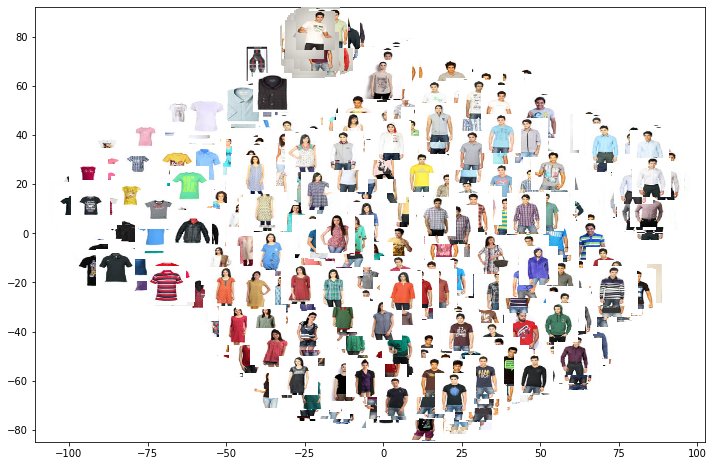

In [ ]:
'''TSNE Visualization of Latent Space'''
def imscatter(x, y, ax, imageData, zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        img = imageData[i]
        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

def computeTSNEProjectionOfLatentSpace(X, display=True):
    # Compute latent space representation
    print("Computing latent space projection...")
    X_encoded, z_logsigma = model.encode(X)

    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize = (12,8))
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.6)
        plt.show()
    else:
        return X_tsne

computeTSNEProjectionOfLatentSpace(train_images[:10000])

###Latent Space Exploration

First, I plotted a histogram for each latent dimension to display the distribution of the data points within each dimension.

Next, I generated a grid to display the linear interpolation between the end points within each latent dimension.

Lastly, I built out a set of interactive sliders to control the value of each latent variable. This is used to query data points directly from the latent space. This interactive plot can be used to discover the individual features that each latent variable extracts from the images (ie. color, type of clothing, patterns).

In [ ]:
'''Distribution of Data Within Each Latent Dimension'''
z_mean, z_logsigma, x_recon = model.call(np.array(train_images), np.array(train_labels))

all_distributions = []
for i in range(latent_dim):
  latent_dist = []
  for encoding in z_mean:
    latent_dist.append(encoding[i])
  all_distributions.append(latent_dist)

num_bins = 20
for i in range(len(all_distributions)):
  print('Latent Dimension #' + str(i) + ":")
  plt.hist(all_distributions[i], num_bins, range = (-3,3))
  plt.show() 

KeyboardInterrupt: ignored

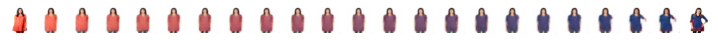

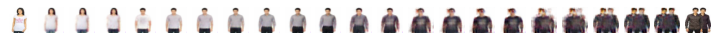

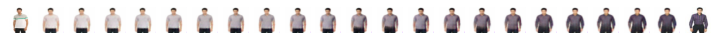

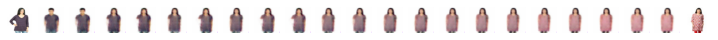

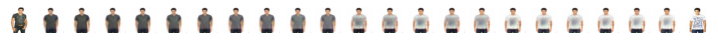

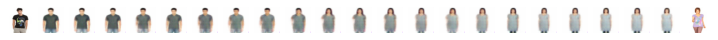

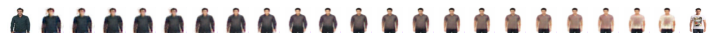

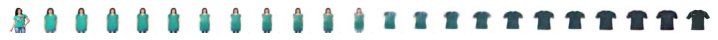

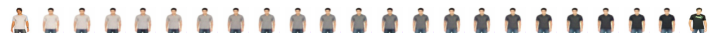

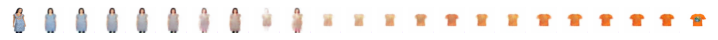

In [ ]:
z_mean, z_logsigma, x_recon = model.call(np.array(train_images), np.array(train_labels))
for j in range(10):
  first = j
  second = j+10
  first_latent_datapoint = z_mean[first]
  second_latent_datapoint = z_mean[second]
  first_logsigma = z_logsigma[first]
  second_logsigma = z_logsigma[second]
  first_label = train_labels[first]
  second_label = train_labels[second]

  delta_latent = (second_latent_datapoint - first_latent_datapoint)
  delta_logsigma = (second_logsigma - first_logsigma)
  delta_y = (second_label - first_label)
  n_steps = 20
  step_size = 1/n_steps

  def plot_reconstructed_images(model, latent_var):
    reconstructions = [train_images[first]]
    for i in range(n_steps+1):
      new_latents = tf.expand_dims(first_latent_datapoint + delta_latent*step_size*i, axis=0)
      new_logsigma = tf.expand_dims(first_logsigma + delta_logsigma*step_size*i, axis=0)
      y = tf.expand_dims(first_label + delta_y*step_size*i, axis=0)
      image_reconstruction = tf.squeeze(model.decode(model.reparameterize(new_latents, new_logsigma, y), apply_sigmoid=False))
      reconstructions.append(image_reconstruction)

    reconstructions.append(train_images[second])
    fig1 = plt.figure(figsize=(22, 22))

    for i in range(len(reconstructions)):
      plt.subplot(1, 40, i + 1)
      plt.imshow(reconstructions[i])
      plt.axis('off')

    plt.show()

  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)

  plot_reconstructed_images(model, i)

  logger.setLevel(old_level)

- Train on virtual desktop (install dependencies – ie. Conda, TensorFlow, etc.)
- Increase number of latent variables
- Add residual layers to model
- Add convolutional filters
- Implement UI AFTER

In [ ]:
# button = widgets.Button(description="Click Me!")
# output = widgets.Output()

# def on_button_clicked(b):
#   with output:
#     print("Button clicked.")

# button.on_click(on_button_clicked)
# display(button, output)

first = 0
second = 1
first_latent_datapoint = z_mean[first]
second_latent_datapoint = z_mean[second]
first_logsigma = z_logsigma[first]
second_logsigma = z_logsigma[second]
first_label = train_labels[first]
second_label = train_labels[second]
delta_latent = (second_latent_datapoint - first_latent_datapoint)
delta_logsigma = (second_logsigma - first_logsigma)
delta_y = (second_label - first_label)
n_steps = 10
step_size = 1/n_steps


'''Sliders For Queried Data'''
def query_data(q_point, new_logsigma, y):
  dists = np.sum(np.square(z_mean - q_point),axis=1)
  closest_point = np.argmin(dists)
  image = tf.squeeze(train_images[closest_point])
  image_reconstruction = tf.squeeze(model.decode(tf.expand_dims(z_mean[closest_point], axis=0)))
  # image_reconstruction = tf.squeeze(model.decode(tf.expand_dims(z_mean[closest_point], axis=0)))
  return image, image_reconstruction

def update_plot(q_point):
  image, image_reconstruction = query_data(q_point)
  image_combined = tf.concat([image, image_reconstruction], axis=1)
  fig = plt.figure(2)

  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)

  im = plt.imshow(image_combined, vmin=0, vmax=1)
  plt.axis('Off')
  plt.show()

  logger.setLevel(old_level)

def f(step_size, new_logsigma, y):
  # new_latents = tf.expand_dims(first_latent_datapoint + delta_latent*step_size, axis=0)
  # new_logsigma = tf.expand_dims(first_logsigma + delta_logsigma*step_size, axis=0)
  # y = tf.expand_dims(first_label + delta_y*step_size*i, axis=0)
  new_logsigma = tf.expand_dims(first_logsigma + delta_logsigma*step_size, axis=0)
  y = tf.expand_dims(first_label + delta_y*step_size*i, axis=0)

  # q_point = tf.expand_dims(first_latent_datapoint + delta_latent*step_size, axis=0)
  q_point = first_latent_datapoint + delta_latent*step_size
  update_plot(q_point)
  return

bounds = (0, 1.0)
interactive_plot = interactive(f, step_size=bounds)
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='step_size', max=1.0), Output()), _dom_classes=('widg…

Latent Dimension #0:


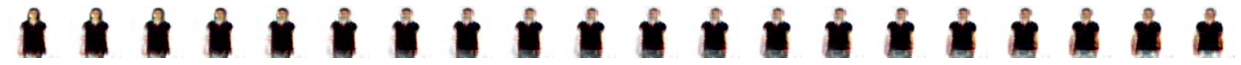

Latent Dimension #1:


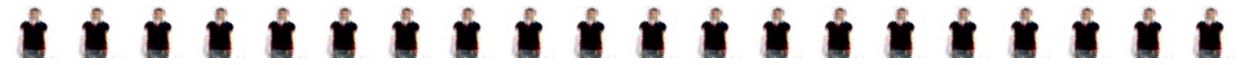

Latent Dimension #2:


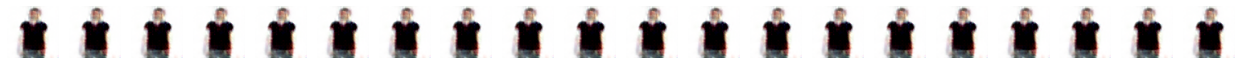

Latent Dimension #3:


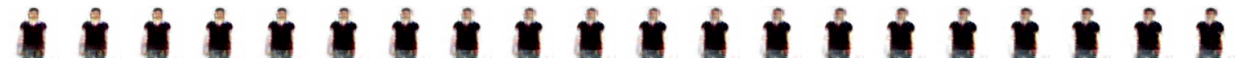

Latent Dimension #4:


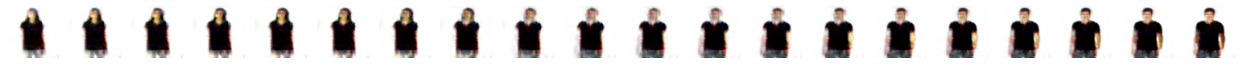

In [ ]:
'''Linear Interpolation Visualization'''
z_mean, z_logsigma, x_recon = model.call(np.array(train_images), np.array(train_labels))

def plot_reconstructed_images(model, latent_var):
  reconstructions = []
  for i in range(-10,10):
    z_mean = np.zeros(8)
    z_mean[latent_var] = i/10.0
    image_reconstruction = tf.squeeze(model.decode(tf.expand_dims(z_mean, axis=0), apply_sigmoid=False))
    reconstructions.append(image_reconstruction)

  fig1 = plt.figure(figsize=(22, 22))

  for i in range(len(reconstructions)):
    plt.subplot(1, 20, i + 1)
    plt.imshow(reconstructions[i])
    plt.axis('off')

  print('Latent Dimension #' + str(latent_var) + ":")
  plt.show()

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

for i in range(latent_dim):
  plot_reconstructed_images(model, i)

logger.setLevel(old_level)

In [ ]:
'''Linear Interpolation Visualization'''
z_mean, z_logsigma, x_recon = model.call(np.array(train_images), np.array(train_labels))

def plot_reconstructed_images(model, latent_var):
  reconstructions = []
  for i in range(-10,10):
    z_mean = np.zeros(13)
    z_mean[latent_var] = i/10.0
    image_reconstruction = tf.squeeze(model.decode(tf.expand_dims(z_mean, axis=0), apply_sigmoid=False))
    reconstructions.append(image_reconstruction)

  fig1 = plt.figure(figsize=(22, 22))

  for i in range(len(reconstructions)):
    plt.subplot(1, 20, i + 1)
    plt.imshow(reconstructions[i])
    plt.axis('off')

  print('Latent Dimension #' + str(latent_var) + ":")
  plt.show()

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

for i in range(latent_dim):
  plot_reconstructed_images(model, i)

logger.setLevel(old_level)

ValueError: ignored

The above linear interpolation of the reconstructed images within each latent dimension allows us to visualize the defining features that the model extracts during the training process.

In [ ]:
'''Sliders For Reconstructed Outputs'''
def update_plot_1(q_point):
  image_reconstruction = tf.squeeze(model.decode(tf.expand_dims(q_point, axis=0), apply_sigmoid=False))
  fig = plt.figure(2)

  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)

  im = plt.imshow(image_reconstruction, vmin=0, vmax=1)
  plt.axis('Off')
  plt.show()

  logger.setLevel(old_level)

def f1(a, b, c, d, e, f, g, h, i, j, k, l, m):
  q_point = np.array([a, b, c, d, e, f, g, h, i, j, k, l, m])
  update_plot_1(q_point)
  return
bounds = (-3.0, 3.0)
interactive_plot_1 = interactive(f1, a=bounds, b=bounds, c=bounds, d=bounds, e=bounds, f=bounds, g=bounds, h=bounds, i=bounds, j=bounds, k=bounds, l=bounds, m=bounds)
interactive_plot_1

interactive(children=(FloatSlider(value=0.0, description='a', max=3.0, min=-3.0), FloatSlider(value=0.0, descr…

In [ ]:
'''Sliders For Queried Data'''
def query_data(q_point):
  dists = np.sum(np.square(z_mean - q_point),axis=1)
  closest_point = np.argmin(dists)
  image = tf.squeeze(train_images[closest_point])
  image_reconstruction = tf.squeeze(model.decode(tf.expand_dims(z_mean[closest_point], axis=0)))
  return image, image_reconstruction

def update_plot_2(q_point):
  image, image_reconstruction = query_data(q_point)
  image_combined = tf.concat([image, image_reconstruction], axis=1)
  fig = plt.figure(2)

  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)

  im = plt.imshow(image_combined, vmin=0, vmax=1)
  plt.axis('Off')
  plt.show()

  logger.setLevel(old_level)

def f2(a, b, c, d, e, f, g, h, i, j, k, l, m):
  q_point = np.array([a, b, c, d, e, f, g, h, i, j, k, l, m])
  update_plot_2(q_point)
  return
bounds = (-3.0, 3.0)
interactive_plot = interactive(f2, a=bounds, b=bounds, c=bounds, d=bounds, e=bounds, f=bounds, g=bounds, h=bounds, i=bounds, j=bounds, k=bounds, l=bounds, m=bounds)
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='a', max=3.0, min=-3.0), FloatSlider(value=0.0, descr…

###Final Remarks

All of this will be published onto my [GitHub](https://github.com/alvinkli)! Special thanks to Professor Daniela Rus, Alexander Amini, Igor Gilitchenski, and Wilko Schwarting for their mentorship!

###Relevant Resources
Here are links to videos, articles, and documents that provide a more detailed explanation of the important deep learning concepts that were covered in this project:

1) [3Blue1Brown Introduction to Neural Networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
*   This series of videos gives one of the clearest explanations of neural networks that I have seen.

2) [MIT 6.S191 Deep Learning Course](https://www.youtube.com/watch?v=njKP3FqW3Sk&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&ab_channel=AlexanderAmini)
*   Lecture 1 (Introduction to Deep Learning) offers a great overview of the core concepts within deep learning.
*   Lecture 3 (Convolutional Neural Networks) goes into detail about how convolutional neural networks work and how they are used to extract features from images.
*   Lecture 4 (Deep Generative Modeling) provides a high level explanation of VAEs and how they can be applied to various deep learning fields.

3) [Towards Data Science Guide to Understanding VAEs](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
*   This article outlines both the basic intuition and deep mathematical concepts behind VAEs. The math is not essential to understanding the code I wrote, but is very interesting nonetheless if you want to truly understand how VAEs work.

4) [TensorFlow VAE Implementation on the MNIST dataset](https://www.tensorflow.org/tutorials/generative/cvae)
*   This tutorial shows how to use TensorFlow to build, train, and test a convolutional variational autoencoder on the famous MNIST datset of black and white images of handwritten numbers.

5) [MIT 6.S191 Debiasing VAE Lab](https://github.com/aamini/introtodeeplearning/blob/master/lab2/solutions/Part2_Debiasing_Solution.ipynb)
*   This lab inspired the architecture for the VAE model and the code structure for the training loop.

6) [TSNE Implementation](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)
*   This article shows how to use the t-SNE algorithm to visualize high dimensional datasets in Python.

7) [Martin Krasser's Deep Feature Consistent Variational Autoencoder](http://krasserm.github.io/2018/07/27/dfc-vae/) 
*   This article explains how to implement a perceptual loss function when training a VAE and the benefits of using this over traditional element-wise reconstruction loss functions.









